<a href="https://colab.research.google.com/github/ibrahimkaya754/GAN/blob/main/dcgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
cd drive/MyDrive/ESEN/Scripts/CGAN_with_Classifier

[Errno 2] No such file or directory: 'drive/MyDrive/ESEN/Scripts/CGAN_with_Classifier'
/content/drive/MyDrive/ESEN/Scripts/CGAN_with_Classifier


In [174]:
## MODULES AND THE DATA IMPORT
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import *
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.losses import *
#from MoGeNA import *
from sklearn.preprocessing import *
from tensorflow.python.platform import build_info as tf_build_info
from scipy import spatial
#from kymatio.numpy import Scattering2D
print(tf_build_info.build_info)

OrderedDict([('cpu_compiler', '/usr/bin/x86_64-linux-gnu-gcc-7'), ('cuda_compute_capabilities', ['compute_37', 'compute_60', 'compute_61', 'compute_70', 'compute_75', 'compute_80']), ('cuda_version', '11.1'), ('cudnn_version', '8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False)])


In [26]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
    print("tensorflow version is: ",tf.__version__)

tensorflow version is:  2.8.0


In [27]:
# Load The Data
def load_wifi_data(data,label,labelClass=['Samsung Galaxy M21', 'Samsung S21', 'Iphone 7 Plus', 'Iphone 8', 'Iphone 12 Pro Max', 'Oppo Realme 6', 'Xiaomi Mi 9T Pro', 'Iphone X', 'Iphone 11']):
    data_wifi   = pickle.load(open(data,"rb"))
    labels_wifi = pickle.load(open(label,"rb"))
    
    labels  = []
    labels_wifi_numeric = np.ndarray(shape=labels_wifi.shape,dtype=np.int16)

#     data_I = np.ndarray((data_wifi.shape[0],int(data_wifi.shape[1]/2),data_wifi.shape[2]),dtype=np.float64)
#     data_Q = np.ndarray((data_wifi.shape[0],int(data_wifi.shape[1]/2),data_wifi.shape[2]),dtype=np.float64)

#     data_I[:,0::1,0] = data_wifi[:,0::2,0]
#     data_Q[:,0::1,0] = data_wifi[:,1::2,0]

#     data_wifi_reshaped = np.ndarray((data_wifi.shape),dtype=np.float64)
#     data_wifi_reshaped = data_wifi_reshaped.reshape(data_wifi_reshaped.shape[0],1024,2)
#     data_wifi_reshaped[:,:,0]= data_I[:,:,0]
#     data_wifi_reshaped[:,:,1]= data_Q[:,:,0]
    
    #scattering = Scattering2D(J=1, shape=(1024, 2))
    #data_wifi = scattering(data_wifi)
    
    print("data_shape:" ,data_wifi.shape)  
    print('label shape: ',labels_wifi.shape)

    for lbl in labels_wifi:
        if lbl not in labels:
            labels.append(lbl)

    #labelsnumeric = [value for value,key in enumerate(labelClass)]

    for val,label in enumerate(labels_wifi):
        labels_wifi_numeric[val] = labelClass.index(label)

    print("labels: ",labels)
    data = {'data'   :data_wifi,
            'labels' :labels_wifi,
            'labelsNum' :labels_wifi_numeric}

    dumbarray = np.zeros((data['labelsNum'].shape[0],9),dtype=np.int16)
    for ii in range(data['labelsNum'].shape[0]):
        indice = labels_wifi_numeric[ii]
        dumbarray[ii,indice] = 1

    data['label1hot'] = dumbarray
    numberOfClasses = len(labels)
    print("number of classes: ",numberOfClasses)
    return data, numberOfClasses

In [28]:
data,numberOfClasses = load_wifi_data(data="../daha_yeni_Data/train_data",label="../daha_yeni_Data/train_label")

data_shape: (20457, 1024, 2)
label shape:  (20457,)
labels:  ['Samsung Galaxy M21', 'Samsung S21', 'Iphone 7 Plus', 'Iphone 8', 'Iphone 12 Pro Max', 'Oppo Realme 6', 'Xiaomi Mi 9T Pro', 'Iphone X', 'Iphone 11']
number of classes:  9


In [29]:
data_val,numberOfClassesVal = load_wifi_data(data="../daha_yeni_Data/test_data",label="../daha_yeni_Data/test_label")

data_shape: (108, 1024, 2)
label shape:  (108,)
labels:  ['Oppo Realme 6', 'Iphone X', 'Samsung Galaxy M21', 'Xiaomi Mi 9T Pro', 'Iphone 7 Plus', 'Iphone 8']
number of classes:  6


In [30]:
#pickle.dump(data,open("data_wavelettransformed.pickle","wb"))
#pickle.dump(data_val,open("data_val_wavelettransformed.pickle","wb"))

In [31]:
# Creating the DataSets - Train and Validation
def CreateDataSet(data):
    dataset = []
    dataset.append(data['data'].reshape(data['data'].shape[0],data['data'].shape[1],data['data'].shape[2],1))
    dataset.append(data['labelsNum'])
    dataset.append(data['label1hot'])
    print('dataset shape: ', dataset[0].shape)
    print('max value before scaling: ', np.max(dataset[0]))
    print('min value before scaling: ', np.min(dataset[0]))
    print(dataset[2].shape)
    return dataset

In [32]:
dataset = CreateDataSet(data)

dataset shape:  (20457, 1024, 2, 1)
max value before scaling:  4.870987841501294
min value before scaling:  -4.723860058350628
(20457, 9)


In [33]:
datasetVal= CreateDataSet(data_val)

dataset shape:  (108, 1024, 2, 1)
max value before scaling:  4.34002448862791
min value before scaling:  -4.11882946115985
(108, 9)


In [34]:
def scaling(TrainSet,ValidationSet):
    scalerx0 = MinMaxScaler((-0.5,0.5))
    scalerx1 = MinMaxScaler((-0.5,0.5))

    scx0 = scalerx0.fit(TrainSet[0][:,:,0,0])
    scx1 = scalerx1.fit(TrainSet[0][:,:,1,0])

    TrainSet[0][:,:,0,0]= scx0.transform(TrainSet[0][:,:,0,0])
    TrainSet[0][:,:,1,0]= scx1.transform(TrainSet[0][:,:,1,0])
    ValidationSet[0][:,:,0,0]= scx0.transform(ValidationSet[0][:,:,0,0])
    ValidationSet[0][:,:,1,0]= scx1.transform(ValidationSet[0][:,:,1,0])
    print('min, max value of I after scaling training dataset: %.3f, %.3f' % (np.min(TrainSet[0][:,:,0,0]),np.max(TrainSet[0][:,:,0,0])))
    print('min, max value of Q after scaling training dataset: %.3f, %.3f' % (np.min(TrainSet[0][:,:,1,0]),np.max(TrainSet[0][:,:,1,0])))
    print('min, max value of I after scaling validation set: %.3f, %.3f' % (np.min(ValidationSet[0][:,:,0,0]),np.max(ValidationSet[0][:,:,0,0])))
    print('min, max value of Q after scaling validation set: %.3f, %.3f' % (np.min(ValidationSet[0][:,:,1,0]),np.max(ValidationSet[0][:,:,1,0])))
    return TrainSet,ValidationSet,[scx0,scx1]
dataset,datasetVal,[scx0,scx1] = scaling(dataset,datasetVal)

min, max value of I after scaling training dataset: -0.500, 0.500
min, max value of Q after scaling training dataset: -0.500, 0.500
min, max value of I after scaling validation set: -0.524, 0.573
min, max value of Q after scaling validation set: -0.583, 0.523


In [35]:
# Defining the Classifier
def define_classifier(in_shape=(1024,2,1), n_classes=numberOfClasses, 
                      filters=[64,32,16,8], neurons=50,
                      strides=[(2,1),(2,2),(2,2),(2,2)],
                      alpha= 0.2, kernelSize= 3, Drop= 0.2,
                      learningRate= 0.001):

    opt      = Adam(lr=learningRate)
    in_image = Input(shape=in_shape)

    layer1 = Reshape((64,32,1))(in_image)
    
    for fltr,strd in zip(filters,strides):
        layer1 = Conv2D(int(round(fltr)), (int(round(kernelSize)),int(round(kernelSize))), 
                        strides=strd, padding='same')(layer1)
        layer1 = LeakyReLU(alpha=alpha)(layer1)

    flatten = Flatten()(layer1)

    layer1 = Dropout(Drop)(flatten)
    featuredescriptor = Dense(int(round(neurons)))(layer1)
    layer1 = LeakyReLU(alpha=alpha)(featuredescriptor)
    layer1 = Dropout(Drop)(layer1)

    out    = Dense(9,activation='softmax')(layer1)

    classifier  = Model(in_image, out)
    classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    classifier.summary()

    descriptor1 = Model(in_image,featuredescriptor)
    descriptor2 = Model(in_image,featuredescriptor)
    return classifier, descriptor1, descriptor2


In [36]:
# CALLBACKS
def Callbacks():
    checkpoint = ModelCheckpoint(filepath="./classifier.hdf5", 
                                 monitor='val_accuracy', verbose=1, 
                                 save_best_only=True, period=1, 
                                 mode='max',save_weights_only=False)
    reduce_lr  = ReduceLROnPlateau(monitor='val_accuracy', 
                                   factor=0.98,
                                   patience=10, 
                                   min_lr=0.0000001, mode='max', verbose=1)
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=250, verbose=1, mode='auto') 
    return checkpoint, reduce_lr, early_stopping
checkpoint, reduce_lr, early_stopping = Callbacks()

In [37]:
# Function for MoGenA
def optClassifier(inp):
    print("parameter set is: ",inp)
    filters      = inp[0:4]
    neurons      = inp[4]
    alpha        = inp[5]
    kernelSize   = inp[6]
    Drop         = inp[7]
    learningRate = inp[8]
    classifier   = define_classifier(in_shape=(9,512,1), n_classes=14, 
                                     filters=filters, neurons=neurons,
                                     strides=[(2,1),(2,2),(2,2),(2,2)],
                                     alpha= alpha, kernelSize= kernelSize, Drop= Drop,
                                     learningRate= learningRate)
    history      = classifier.fit(dataset[0], dataset[2], 
                                  batch_size=int(round(inp[9])), 
                                  epochs=int(round(inp[10])), 
                                  validation_data=(datasetVal[0],datasetVal[2]), 
                                  #validation_split = 0.25,
                                  verbose=1, shuffle=True,
                                  callbacks=[checkpoint, reduce_lr])
    minimization_param = -np.max(history.history['val_accuracy'])
    return minimization_param

In [38]:
# Genetic Algorithm
runOpt = False
if runOpt:
  ga = Mogena.MoGenA(fitness_func         = optClassifier, 
                    number_of_generation = 20,
                    number_of_variables  = 11,
                    population_size      = 30,
                    lower_boundaries     = [8  ,8  ,8  ,8  ,8  ,0.1,3,0.1,0.00001,64  ,20 ],
                    upper_boundaries     = [250,250,250,250,250,0.5,7,0.5,0.001  ,1024,200],
                    use_saved_data       = False)
  result =  {'best_fitness_ever'            : ga.best_fitness_ever,
            'best_individual_decoded_ever' : ga.best_individual_decoded_ever}

In [39]:
#result

In [40]:
# PostProcessing Of GA
optParams= ["filter0","filter1","filter2","filter3","DenseNeurons","LeakyReluAlpha","kernelSize","DropOutRatio",
            "LearningRate","batchSize","Epochs"]
bestEver= [int(round(246.83139228339436)),
           int(round(154.999)),
           int(round(75.258)),
           int(round(213.6516)),
           int(round(183.0685)),
           0.141,
           int(round(6.666)),
           0.205,
           0.000455,
           int(round(191.8847)),
           int(round(30))]
print(bestEver)

[247, 155, 75, 214, 183, 0.141, 7, 0.205, 0.000455, 192, 30]


In [41]:
# Reloading the Optimized Classifier to BackTest
def ClassifierOptimized(inp,loadweights=True):
    print("parameter set is: ",inp)
    filters      = inp[0:4]
    neurons      = inp[4]
    alpha        = inp[5]
    kernelSize   = inp[6]
    Drop         = inp[7]
    learningRate = inp[8]
    classifier,d1,d2   = define_classifier(in_shape=(1024,2,1), n_classes=14, 
                                     filters=filters, neurons=neurons,
                                     strides=[(2,1),(2,2),(2,2),(2,2)],
                                     alpha= alpha, kernelSize= kernelSize, Drop= Drop,
                                     learningRate= learningRate)
    tf.keras.utils.plot_model(classifier,show_shapes=True)
    if loadweights:
      classifier.load_weights("./classifier.hdf5")
    history      = classifier.fit(dataset[0], dataset[2], 
                                  batch_size=int(round(inp[9])), 
                                  epochs=int(round(inp[10])), 
                                  validation_data=(datasetVal[0],datasetVal[2]), 
                                  verbose=1, shuffle=True,
                                  callbacks=[checkpoint, reduce_lr])
    return classifier,history,d1,d2

In [ ]:
# Generate Classifier
loadWeights = True
classifier,history,d1,d2= ClassifierOptimized(bestEver,loadWeights)

Below is the section to find Cosine Similarity (CS) of the Classes
The CS is calculated for every class pairs, e.g. 0-0, 0,1, 0,2, etc.

dict_mean_cos is the dictionary keeping all the values for CS.

In [182]:
## We define CS4OriginalData function to make the calculation for CS for all class pairs.
## The dictionary "dict_mean_cos" is created inside this function.
def CS4OriginalData():
  nOfClass= dataset[2].shape[1]
  dict_mean_cos = {str(ii): {"indices":[]} for ii in range(nOfClass)}
  total_DataNumber = 0

  for key in dict_mean_cos.keys():
    for ii in range(len(dataset[1])):
      if dataset[1][ii] == int(key):
        dict_mean_cos[key]["indices"].append(ii)

  for key in dict_mean_cos.keys():
    dict_mean_cos[key]["shape"] = dataset[1][dict_mean_cos[key]["indices"]].shape[0]
    print("number of data existing for each class %s: %d" % (key,dict_mean_cos[key]["shape"]))
    total_DataNumber = total_DataNumber + dict_mean_cos[key]["shape"]
  
  print("total_data_number: %d" % (total_DataNumber))
  print("dataset shape is: ", dataset[1].shape[0])
  print("--------------------------------------------")
  for key1 in dict_mean_cos.keys():
    for key2 in dict_mean_cos.keys():
      #print("the cosine similarity is calculated for %s and %s " % (key1,key2))
      res1 = d1.predict(dataset[0][dict_mean_cos[key1]["indices"]])
      res2 = d2.predict(dataset[0][dict_mean_cos[key2]["indices"]])
      list_cs = []
      for ii in range(50):
        ind1, ind2 = np.random.randint(0,1000,2)
        cosinesimilarity = 1- spatial.distance.cosine(res1[ind1], res2[ind2])
        #print(cosinesimilarity)
        list_cs.append(cosinesimilarity)
      string = "mean cosine similarity for %s and %s" % (key1,key2)
      print("%s is: %.3f" % (string,np.mean(list_cs)))
      dict_mean_cos[key1][string] = np.mean(list_cs)
    print("********************************************")
  return dict_mean_cos
dict_mean_cos = CS4OriginalData()

number of data existing for each class 0: 2445
number of data existing for each class 1: 1712
number of data existing for each class 2: 2445
number of data existing for each class 3: 2445
number of data existing for each class 4: 2445
number of data existing for each class 5: 2445
number of data existing for each class 6: 2445
number of data existing for each class 7: 1630
number of data existing for each class 8: 2445
total_data_number: 20457
dataset shape is:  20457
--------------------------------------------
mean cosine similarity for 0 and 0 is: 0.771
mean cosine similarity for 0 and 1 is: 0.238
mean cosine similarity for 0 and 2 is: 0.180
mean cosine similarity for 0 and 3 is: 0.079
mean cosine similarity for 0 and 4 is: 0.483
mean cosine similarity for 0 and 5 is: 0.517
mean cosine similarity for 0 and 6 is: 0.336
mean cosine similarity for 0 and 7 is: 0.091
mean cosine similarity for 0 and 8 is: 0.076
********************************************
mean cosine similarity for 1 and

Below is the section where we load the synthetically generated data and compare it with the original one using cosine similarity.

In [183]:
def load_synthetic_data(data_location):
  synthetic_data   = pickle.load(open(data_location,"rb"))
  synthetic_data[:,:,0]= scx0.transform(synthetic_data[:,:,0])
  synthetic_data[:,:,1]= scx1.transform(synthetic_data[:,:,1])
  print("Synthetic Data Shape is: ", synthetic_data.shape)
  synthetic_data_result = classifier.predict(synthetic_data)
  listClassifiedSyntheticData = [np.argmax(synthetic_data_result[ii]) for ii in range(len(synthetic_data))]
  print("Generated Classes are: ", listClassifiedSyntheticData)
  return synthetic_data, listClassifiedSyntheticData
synthetic_data, listClassifiedSyntheticData= load_synthetic_data("../mygenerateddata_normal2")

Synthetic Data Shape is:  (200, 1024, 2)
Generated Classes are:  [2, 2, 8, 7, 8, 8, 8, 8, 8, 2, 8, 2, 2, 8, 2, 8, 8, 2, 5, 8, 4, 8, 8, 8, 8, 8, 2, 2, 4, 2, 2, 8, 8, 8, 2, 2, 8, 2, 8, 2, 8, 8, 2, 2, 4, 2, 8, 8, 8, 2, 8, 4, 8, 8, 8, 8, 8, 8, 2, 8, 8, 2, 8, 8, 4, 8, 8, 2, 7, 8, 7, 8, 8, 8, 8, 8, 8, 2, 8, 8, 8, 2, 2, 8, 8, 2, 2, 8, 4, 2, 4, 2, 8, 8, 2, 4, 8, 8, 8, 8, 2, 8, 3, 8, 8, 2, 2, 8, 8, 8, 8, 8, 4, 2, 8, 8, 2, 2, 8, 8, 8, 8, 2, 8, 8, 4, 8, 8, 8, 8, 2, 2, 2, 8, 2, 8, 8, 2, 2, 8, 8, 8, 4, 2, 8, 2, 2, 8, 2, 8, 4, 8, 2, 8, 2, 8, 2, 2, 7, 8, 8, 8, 2, 2, 8, 2, 2, 8, 8, 2, 8, 8, 8, 7, 2, 2, 2, 8, 8, 8, 2, 2, 8, 8, 8, 2, 4, 2, 2, 8, 8, 8, 8, 7, 8, 8, 8, 8, 8, 8]


In [ ]:
## CompareCS4SynData is to compare the cosine similarity for the synthetic (syn) data and the original data.
## We compare the synthetic data classes determined by the classifier with the original classes existing in the original dataset
def CompareCS4SynData(synthetic_data,listClassifiedSyntheticData):
  res2 = d2.predict(synthetic_data)
  for key,value in enumerate(listClassifiedSyntheticData):
    res1 = d1.predict(dataset[0][dict_mean_cos[str(value)]["indices"]])
    list_cs = []
    for ii in range(50):
      ind1 = np.random.randint(0,1000,1)
      cosinesimilarity = 1- spatial.distance.cosine(res1[ind1], res2[key])
      #print(cosinesimilarity)
      list_cs.append(cosinesimilarity)
    string = "mean cosine similarity for class %s and 'newly generated class %s'" % (value,value)
    print("%s is: %.3f" % (string,np.mean(list_cs)))
    #dict_mean_cos[key1][string] = np.mean(list_cs)
CompareCS4SynData(synthetic_data,listClassifiedSyntheticData)

mean cosine similarity for class 2 and 'newly generated class 2' is: 0.530
mean cosine similarity for class 2 and 'newly generated class 2' is: 0.620
mean cosine similarity for class 8 and 'newly generated class 8' is: 0.683
mean cosine similarity for class 7 and 'newly generated class 7' is: 0.590
mean cosine similarity for class 8 and 'newly generated class 8' is: 0.659
mean cosine similarity for class 8 and 'newly generated class 8' is: 0.643
mean cosine similarity for class 8 and 'newly generated class 8' is: 0.588
mean cosine similarity for class 8 and 'newly generated class 8' is: 0.560
mean cosine similarity for class 8 and 'newly generated class 8' is: 0.705
mean cosine similarity for class 2 and 'newly generated class 2' is: 0.572
mean cosine similarity for class 8 and 'newly generated class 8' is: 0.642
mean cosine similarity for class 2 and 'newly generated class 2' is: 0.667
mean cosine similarity for class 2 and 'newly generated class 2' is: 0.606
mean cosine similarity fo

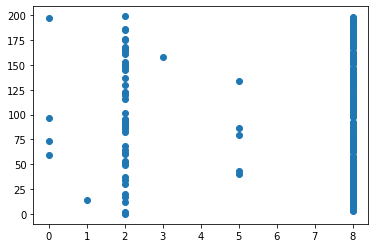

In [ ]:
plt.scatter(list_synthetic_data_result,np.arange(len(list_synthetic_data_result)))

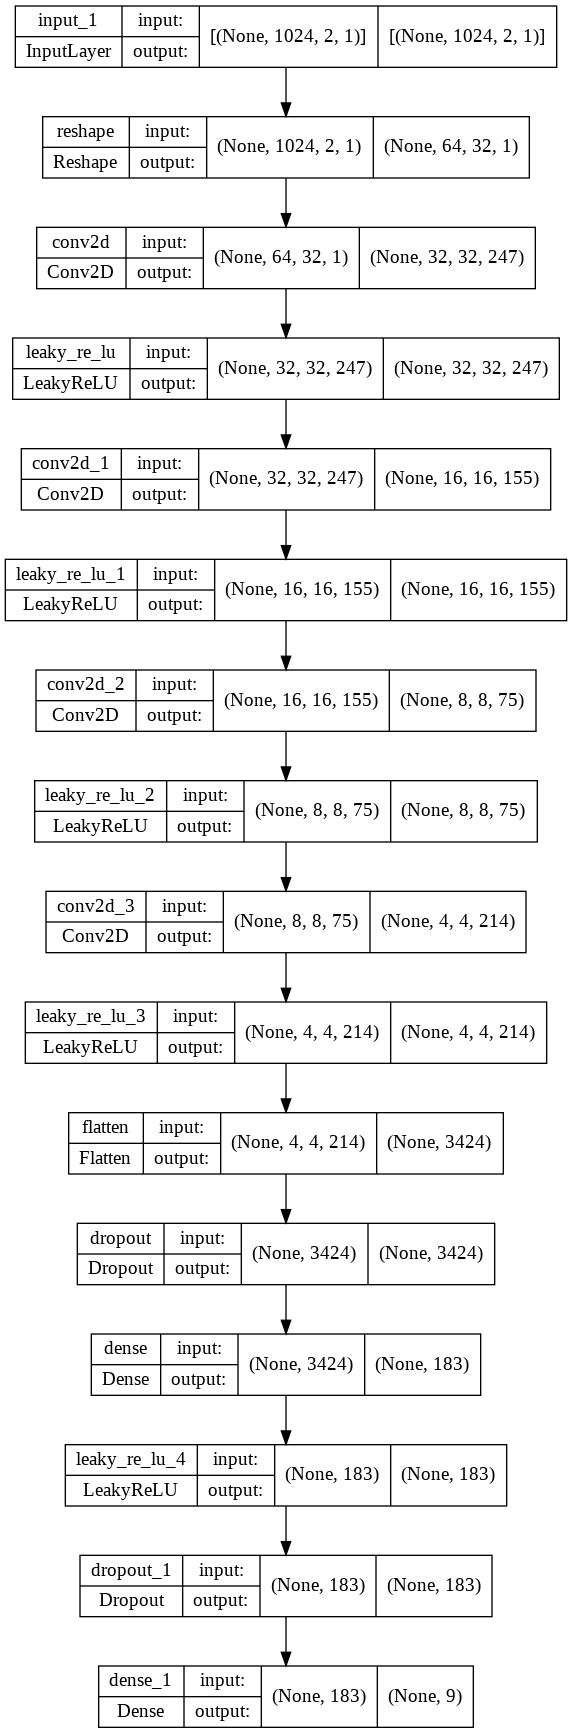

In [ ]:
tf.keras.utils.plot_model(classifier,show_shapes=True)

In [ ]:
# Postprocess
def postprocess(model,dataset):
    classifier.load_weights("./classifier.hdf5")
    results = model.predict(dataset[0])
    list_class = []
    for ii in range(results.shape[0]):
        list_class.append(np.argmax(results[ii]))

    counterTrue  = 0
    counterFalse = 0
    for ii in range(len(list_class)):
        if list_class[ii] == dataset[1][ii]:
            counterTrue = counterTrue + 1
        else:
            counterFalse = counterFalse + 1
    print("True:%d    False:%d" % (counterTrue,counterFalse))
    return list_class,counterTrue,counterFalse

In [ ]:
list_class,counterTrue,counterFalse=postprocess(classifier,datasetVal)

True:86    False:22


In [ ]:
## GENERATIVE MODEL (CONDITIONAL GAN)

In [ ]:
class Spectral_Norm(Constraint):
    def __init__(self, power_iters=5):
        self.n_iters = power_iters
        
    def l2_normalize(self, x, eps=1e-12):
        return x / tf.linalg.norm(x + eps)

    def __call__(self, w):
        flattened_w = tf.reshape(w, [w.shape[0], -1])
        u = tf.random.normal([flattened_w.shape[0]])
        v = tf.random.normal([flattened_w.shape[1]])
        for i in range(self.n_iters):
            v = tf.linalg.matvec(tf.transpose(flattened_w), u)
            v = self.l2_normalize(v)
            u = tf.linalg.matvec(flattened_w, v)
            u = self.l2_normalize(u)
        sigma = tf.tensordot(u, tf.linalg.matvec(flattened_w, v), axes=1)
        return w / sigma

    def get_config(self):
        return {'n_iters': self.n_iters}

In [ ]:
# optParams= ["filter0","filter1","filter2","filter3","DenseNeurons","LeakyReluAlpha","kernelSize","DropOutRatio",
#             "LearningRate","batchSize","Epochs"]
# bestEver= [int(round(246.83139228339436)),
#            int(round(154.999)),
#            int(round(75.258)),
#            int(round(213.6516)),
#            int(round(183.0685)),
#            0.141,
#            int(round(6.666)),
#            0.205,
#            0.000455,
#            int(round(191.8847)),
#            int(round(30))]
# print(bestEver)

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(1024,2,1), n_classes=numberOfClasses, convDim='2D'):
    # label input
    act   = "tanh"
    const = Spectral_Norm()
    in_label = Input(shape=(1,16))
    # embedding for categorical input
    li = Embedding(16, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    if convDim == '1D':
        # reshape to additional channel
        li = Reshape((in_shape[0], in_shape[1]))(li)
        # image input
        in_image = Input(shape=in_shape[0:2])
        # concat label as a channel
        merge = Concatenate()([in_image, li])
        merge = Reshape((64,64))(merge)
        # downsample
        layer1 = Conv1D(128, (3), strides=(2), padding='same',
                        kernel_initializer = glorot_normal(),
                        kernel_constraint= const)(merge)
        layer1 = LeakyReLU(alpha=0.2)(layer1)

        layer1 = Conv1D(64, (3), strides=(2), padding='same',
                        kernel_initializer = glorot_normal(),
                        kernel_constraint= const)(layer1)
        layer1 = LeakyReLU(alpha=0.2)(layer1)

        layer1 = Conv1D(32, (3), strides=(2), padding='same',
                        kernel_initializer = glorot_normal(),
                        kernel_constraint= const)(layer1)
        layer1 = LeakyReLU(alpha=0.2)(layer1)

    else:
        leakyReluAlpha = 0.141
        ksize = (7,7)
        # reshape to additional channel
        li = Reshape((in_shape[0], in_shape[1], 16))(li)
        # image input
        in_image = Input(shape=in_shape)
        # concat label as a channel
        merge = Concatenate()([in_image, li])
        merge = Reshape((64,32,17))(merge)
        # downsample
        layer1 = Conv2D(247, ksize, strides=(2,1), padding='same',
                        kernel_initializer = glorot_normal(),
                        kernel_constraint= const)(merge)
        layer1 = LeakyReLU(alpha=leakyReluAlpha)(layer1)

        layer1 = Conv2D(155, ksize, strides=(2,2), padding='same',
                        kernel_initializer = glorot_normal(),
                        kernel_constraint= const)(layer1)
        layer1 = LeakyReLU(alpha=leakyReluAlpha)(layer1)

        layer1 = Conv2D(75, ksize, strides=(2,2), padding='same',
                        kernel_initializer = glorot_normal(),
                        kernel_constraint= const)(layer1)
        layer1 = LeakyReLU(alpha=leakyReluAlpha)(layer1)
        
        layer1 = Conv2D(214, ksize, strides=(2,2), padding='same',
                        kernel_initializer = glorot_normal(),
                        kernel_constraint= const)(layer1)
        layer1 = LeakyReLU(alpha=leakyReluAlpha)(layer1)

    layer1 = Flatten()(layer1)
    layer1 = Dropout(0.2)(layer1)
    layer1 = Dense(183)(layer1)
    layer1 = LeakyReLU(alpha=leakyReluAlpha)(layer1)
    layer1 = Dropout(0.2)(layer1)

    # output
    out_layer = Dense(1, activation='sigmoid')(layer1)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.000455)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
# size of the latent space
latent_dim = 100

In [ ]:
# define the standalone generator model
def define_generator(latent_dim, n_classes=numberOfClasses, convDim='2D'):
    # label input
    act = "tanh"
    in_label = Input(shape=(1,16))
    # embedding for categorical input
    li = Embedding(16, 50)(in_label)
    # linear multiplication
  
    if convDim== '1D':
        n_nodes = 8 * 16 
        li = Dense(n_nodes)(li)
        # reshape to additional channel
        li = Reshape((64, 2))(li)
        # image generator input
        in_lat = Input(shape=(latent_dim,))
        # foundation for 7x7 image
        n_nodes = 64 * 64
        gen = Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((64, 64))(gen)
        # merge image gen and label input
        merge = Concatenate()([gen, li])
          # upsample to 14x14
        gen = Conv1DTranspose(16, (4), strides=(4), padding='same',kernel_initializer = glorot_normal())(merge)
        gen = LeakyReLU(alpha=0.2)(gen)
        # upsample to 28x28
        gen = Conv1DTranspose(16, (4), strides=(4), padding='same',kernel_initializer = glorot_normal())(gen)
        gen = LeakyReLU(alpha=0.2)(gen)

        gen = Conv1DTranspose(16, (4), strides=(2), padding='same',kernel_initializer = glorot_normal())(gen)
        gen = LeakyReLU(alpha=0.2)(gen)
        # output
        gen = Conv1D(1, (4), activation='tanh', padding='same',kernel_initializer = glorot_normal())(gen)
        out_layer = Reshape((1024, 2))(gen)
    else:
        n_nodes = 4 * 4
        li = Dense(n_nodes)(li)
        # reshape to additional channel
        li = Reshape((16, 4*4, 1))(li)
        # image generator input
        in_lat = Input(shape=(latent_dim,))
        # foundation for 7x7 image

        n_nodes = 4 * 4 * 16
        gen = Dense(n_nodes)(in_lat)
        gen = LeakyReLU(alpha=0.2)(gen)
        gen = Reshape((16, 4*4, 1))(gen)
        # merge image gen and label input
        merge = Concatenate()([gen, li])
        # upsample to 14x14
        gen = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same',kernel_initializer = glorot_normal())(merge)
        gen = LeakyReLU(alpha=0.2)(gen)

        gen = Conv2DTranspose(64, (2,2), strides=(2,1), padding='same',kernel_initializer = glorot_normal())(gen)
        gen = LeakyReLU(alpha=0.2)(gen)

        gen = Conv2DTranspose(32, (2,2), strides=(1,1), padding='same',kernel_initializer = glorot_normal())(gen)
        gen = LeakyReLU(alpha=0.2)(gen)

        gen = Conv2DTranspose(16, (2,2), strides=(1,1), padding='same',kernel_initializer = glorot_normal())(gen)
        gen = LeakyReLU(alpha=0.2)(gen)

    # output
    
        gen = Conv2D(1, (4,4), strides=(1,1), activation='tanh', padding='same',
                     kernel_initializer = glorot_normal())(gen)
    out_layer = Reshape((1024, 2, 1))(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    model.summary()
    return model

In [ ]:
# Inception Score for measuring the similarity between the generated signals and the real ones, using KL Divergence
def InceptionScore(nelem=100):
    for tt in range(1):
        RealImageList = []
        latent_points, labels = generate_latent_points(latent_dim=100, n_samples=30)
        for elem in range(labels.shape[0]):
            nolabel = np.argmax(labels[elem])
            for ii in range(1000):
                if dataset[1][ii] == nolabel:
                    indice = ii
        
            RealImageList.append(dataset[0][indice])

        RealImageList= np.array(RealImageList)
        X1  = g_model.predict([latent_points, labels])
        kl  = KLDivergence()
        bce = BinaryCrossentropy(from_logits=True)

    return kl(RealImageList,X1).numpy()

In [ ]:
def Ganloss(y_true,y_pred,klprev):
    bce = BinaryCrossentropy(from_logits=True)

    loss = 0.5* tf.reduce_sum(bce(y_true,y_pred)+klprev)
    return loss

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    #d_model.trainable = False

    in_label = Input(shape=(1,16))
    in_lat = Input(shape=(latent_dim,))

    gen_out = g_model([in_lat,in_label])

    gan_out = d_model([gen_out,in_label])

    # get noise and label inputs from generator model
    #gen_noise, gen_label = g_model.input
    # get image output from the generator model
    #gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    #gan_output = d_model([gen_output, gen_label])

    # define gan model as taking noise and label and outputting a classification
    model = Model([in_lat,in_label], gan_out)
    # compile model
    opt = Adam(lr=0.0001,beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    #model.compile(loss=Ganloss, optimizer=opt)
    model.summary()

    return model

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels, onehotenc = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels, onehotenc = images[ix], labels[ix], onehotenc[ix]
	onehotenc = onehotenc.reshape((n_samples,1,16))
	# generate class labels
	y = np.ones((n_samples, 1))
	return [X, onehotenc], [y, onehotenc]

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=14):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, 14, n_samples)
	dumbarray = np.zeros((n_samples,1,16))
	for ii in range(n_samples):
		indice = labels[ii]
		dumbarray[ii,0,indice] = 1
	return [z_input, dumbarray]

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, z_input, labels_input, n_samples):
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [ ]:
# create the discriminator
d_model = define_discriminator(convDim='2D')
tf.keras.utils.plot_model(d_model, show_shapes=True)

In [ ]:
# create the generator
g_model = define_generator(latent_dim,convDim='2D')
tf.keras.utils.plot_model(g_model, show_shapes=True)

In [ ]:
# create the gan
gan_model = define_gan(g_model, d_model)
tf.keras.utils.plot_model(gan_model,show_shapes=True)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, 
          n_epochs=100, n_batch=128, load_saved_data=True, 
          dclip_value=0.1, gclip_value=0.1):
    
    if load_saved_data:
        g_model.load_weights('cgan_generator.hdf5')
        d_model.load_weights('cgan_discriminator.hdf5')
  
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        if i%10 == 0:
          # save the generator model
            g_model.save('cgan_generator.hdf5')
            d_model.save('cgan_discriminator.hdf5')
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            list_z_input = []
            list_labels_input =[]
            d_model.trainable = True
            for ii in range(5):
                # get randomly selected 'real' samples
                [X_real, labels_real], [y_real, onehotenc] = generate_real_samples(dataset, n_batch)
                # update discriminator model weights
                d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
                # generate 'fake' examples
                # prepare points in latent space as input for the generator
                [z_input, labels_input]  = generate_latent_points(latent_dim, n_batch)
                [X_fake, labels], y_fake = generate_fake_samples(g_model, z_input, labels_input, n_batch)
                # update discriminator model weights
                d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)

                list_z_input.append(z_input)
                list_labels_input.append(labels_input)

                for l in d_model.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -dclip_value, dclip_value) for w in weights]
                    l.set_weights(weights)

            zinput = np.ndarray((5*n_batch, latent_dim))
            labelsinput = np.ndarray((5*n_batch,1,16))
            cntr = 0
            for ii in range(5):
                for jj in range(n_batch):
                    zinput[cntr,:] = list_z_input[ii][jj,:]
                    labelsinput[ii*n_batch:(ii+1)*n_batch,:] = list_labels_input[ii][:]
                    cntr = cntr + 1

            # create inverted labels for the fake samples
            y_gan = np.ones((5*n_batch, 1))
            # update the generator via the discriminator's error
            d_model.trainable = False
            #g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            g_loss = gan_model.train_on_batch([zinput, labelsinput], y_gan)

            for l in g_model.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -gclip_value, gclip_value) for w in weights]
                l.set_weights(weights)
            # summarize loss on this batch
            try:
                inceptionScore = InceptionScore(nelem=n_batch)
            except:
                continue
            print('epoch: %d/%d, %d/%d, dloss_real: %.3f, dloss_fake: %.3f, gloss: %.3f, IS: %s' %\
                  (i+1, n_epochs, j+1, bat_per_epo, d_loss1, d_loss2, g_loss, inceptionScore))

        ix = np.random.randint(0,half_batch)
        #print('generated label : ', labels)
        #print("***************************")
        #print('real label      : ', labels_real)
        X_real_abs = X_real[ix,:,0] + 1j*X_real[ix,:,1]
        X_fake_abs = X_fake[ix,:,0] + 1j*X_fake[ix,:,1]

        print('\n')
        plt.figure(figsize=(15,6))
        plt.plot(np.abs(X_real_abs))
        plt.plot(np.abs(X_fake_abs))
        plt.show()
        print('\n')

    # save the generator model
    g_model.save('cgan_generator.hdf5')
    d_model.save('cgan_discriminator.hdf5')

In [ ]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim, 
      n_epochs=100, n_batch=192, load_saved_data=True, 
      dclip_value=0.01, gclip_value=0.1)    

In [ ]:
g_model.load_weights('cgan_generator.hdf5')
d_model.load_weights('cgan_discriminator.hdf5')

In [ ]:
# example of loading the generator model and generating images
def generateNewSamples():
	n_samples_perclass = 150
	n_classes          = numberOfClasses
	
	# generate points in latent space as input for the generator
	def generate_latent_points(latent_dim, n_samples_perclass, n_classes=n_classes):
		numberOfsamples = n_samples_perclass*n_classes
		# generate points in the latent space
		x_input = randn(latent_dim * numberOfsamples)
		# reshape into a batch of inputs for the network
		z_input = x_input.reshape(numberOfsamples, latent_dim)
		# generate labels
		onehot = np.zeros((n_classes*n_samples_perclass,1,16))
		labels = np.ndarray((n_classes*n_samples_perclass,)) 
		for ii in range(n_classes):
			for jj in range(n_samples_perclass):
				onehot[ii*n_samples_perclass+jj,0,ii] = 1
				labels[ii*n_samples_perclass+jj] = ii
		return [z_input, labels, onehot]
	

	# load model
	model = load_model('cgan_generator.hdf5')
	# generate images
	latent_points, labels, onehot = generate_latent_points(latent_dim=100, n_samples_perclass=n_samples_perclass)

	# generate images
	X1  = model.predict([latent_points, onehot])
	#X1  = inv_scaling(X1,max,min)
	mygenerateddata = []
	mygenerateddata.append(X1)
	mygenerateddata.append(labels)
	mygenerateddata.append(onehot)

	#print(X1.shape)
	for ii in range(n_samples_perclass*n_classes):
		print("label: ",labels[ii])
		plt.plot(X1[ii,:,0,0])
		plt.plot(X1[ii,:,1,0])
		plt.show()
		print("******************")

	return mygenerateddata

In [ ]:
mygenerateddata = generateNewSamples()

In [ ]:
mygenerateddata_inv = mygenerateddata
mygenerateddata_inv[0][:,:,0,0] = scx0.inverse_transform(mygenerateddata[0][:,:,0,0])
mygenerateddata_inv[0][:,:,1,0] = scx1.inverse_transform(mygenerateddata[0][:,:,1,0])

In [ ]:
import pickle
pickle.dump(mygenerateddata_inv,open("generated_inv01.pickle","wb"))
mygenerateddata_inv[0].shape

In [ ]:
plt.plot(mygenerateddata_inv[0][0:100,:,1,0])
plt.show()

In [ ]:
def mergeDatasets():
    print("generateddata shape: ",mygenerateddata[0].shape)
    print("original data shape before merging: ",dataset[0].shape)

    mygenerateddata[2] = mygenerateddata[2].squeeze()

    list_data_base = [dataset,mygenerateddata]
    total_data = len(dataset[0]) + len(mygenerateddata[0])

    ## Merging the Generated data set to the existing one
    newdataset = np.ndarray((total_data,dataset[0].shape[1],dataset[0].shape[2],dataset[0].shape[3]))
    newlabels  = np.ndarray((total_data,))
    newonehot  = np.ndarray((total_data,16))

    newdataset[0:len(dataset[0])] = dataset[0]
    newdataset[len(dataset[0]):] = mygenerateddata[0]

    newlabels[0:len(dataset[1])] = dataset[1]
    newlabels[len(dataset[1]):] = mygenerateddata[1]

    newonehot[0:len(dataset[2])] = dataset[2]
    newonehot[len(dataset[2]):] = mygenerateddata[2]

    print("dataset shape after merging: ",newdataset.shape)
    datasetNew = [newdataset,newlabels,newonehot]
    return datasetNew


In [ ]:
MergedDataset = mergeDatasets()

In [ ]:
list_classLabels,counterTrue,counterFalse=postprocess(classifier,dataset)
list_classLabelsGen,counterTrue,counterFalse=postprocess(classifier,mygenerateddata)
list_classLabelsMerged,counterTrue,counterFalse=postprocess(classifier,MergedDataset)


In [ ]:
print("Generated Classes after Conditional GAN training")
plt.scatter(np.arange(len(list_classLabelsGen)),mygenerateddata[1])
plt.show()

In [ ]:
print("Generated Classes Determined by the Classifier Trained with Original Dataset")
plt.scatter(np.arange(len(list_classLabelsGen)),list_classLabelsGen)
plt.show()

Sonuçlar incelendiğinde:
    - Her sınıftan eşit sayıda sınıf oluşturması gerekirken bunu yapmadığı,
    - Conditional GAN'ın 5, 7, ve 8. sınıflardan yeni sınıf oluşturmada zorlandığı,
    - oluşturulan sınıfların classifier tarafından sınıflandırıldığında, farklı label'lı sınıf olarak gördüğü
anlaşılmakta.

Ancak, yine de kontrolsüz de olsa, birden fazla sınıf için yeni veri üretebilmiş gibiyiz. Bunu test etmek için knn vb yöntemleri de kullanarak sınıflandırma yapalım.